# Исследование данных о рекламных кампаниях развлекательного приложения "РP"

## Библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

## Первый взгляд на данные

In [2]:
visits, orders, costs = (pd.read_csv(r'D:\Analysis\repository_prakticum\visits_info_short.csv', parse_dates=['Session Start', 'Session End']), #визиты
                        pd.read_csv(r'D:\Analysis\repository_prakticum\orders_info_short.csv', parse_dates=['Event Dt']), #заказы
                        pd.read_csv(r'D:\Analysis\repository_prakticum\costs_info_short.csv', 
                                    converters={'dt': lambda x: pd.to_datetime(x).date()})) #расходы

In [3]:
#визиты
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
#заказы
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
#расходы
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Приведем названия столбцов к нижнему регистру
и выведем общую информацию о содержащихся данных.

In [6]:
data = [visits, orders, costs]
for table in data:
    table.columns = table.columns.str.lower()
    table.columns = table.columns.str.replace(' ', '_')
    table.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 94

In [7]:
#Проверим наличие явных дубликатов.
for table in data:
    print(table.duplicated().sum())

0
0
0


*Комментарий.* 
- Типы данных соответствуют содержащейся в ячейках инфомрации.
- Судя по колонке "Non-Null" в данных нет пропусков и нет необходимости их изучать и обрабатывать.
- Дубликаты отсуствуют.

Данные готовы к анализу.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Функции для вычисления значений метрик

In [8]:
#Функция для создания профилей пользователей.

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
#Функция для подсчёта Retention Rate.

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
#Функция для подсчёта конверсии.

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
#Функция для подсчёта LTV.

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для построения графиков

In [12]:
#Функция для сглаживания данных.

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [13]:
#Функция для построения графика Retention Rate.

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
#Функция для построения графика конверсии.

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
#Функция для визуализации LTV и ROI.

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## EDA

### Профили пользователей

In [16]:
#Получим профили пользователей, вызвав функцию get_profiles.
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [17]:
#Найдем максимальную и минимальную даты привлечения пользователей.
date_min = profiles['first_ts'].min()
date_max = profiles['first_ts'].max()

print(f'Дата привлечения пользователей: минимальная - {date_min}, максимальная - {date_max}.')

Дата привлечения пользователей: минимальная - 2019-05-01 00:00:41, максимальная - 2019-10-27 23:59:04.


**Вывод:** Таблица профилей пользователей содержит 150 008 строк и 9 столбцов. В ней представлены данные о привлеченных пользователях с 1 мая 2019 года по 27 октября 2019 года.

### Страны

#Далее решается ряд однотипных задач. Определим для ее решения функцию `profile_criterion`.

In [18]:
def profile_criterion(criterion):
    #Отразим количество пользователей в категории и % платящих из них в сводной таблице.
    prof_crit = (pd
                .pivot_table(data=profiles,
                            index=criterion,
                            values=['user_id', 'payer'],
                            aggfunc={'user_id': 'nunique',
                                    'payer': 'sum'})
                .rename(columns={'user_id': 'group_by_criterion'})
                )
    #Рассчитаем % платящих пользователей с точностью до 2 знака после запятой.
    prof_crit['percent_of_payers'] = round((prof_crit['payer']*100 / prof_crit['group_by_criterion']), 2)
                                                                                                
    prof_crit = (prof_crit
                 .drop(columns=['payer']) #Удалим ненужный стобец.
                 .sort_values(by=['percent_of_payers'], ascending=False) #Остортируем данные по убыванию % платящих пользователей.
                 )
    #Добавим визуализациюю
    prof_crit.plot(kind='bar',
                subplots=True,
                sharex=True,
                width=0.8,
                edgecolor='black',
                legend=False)
    plt.show();
    #Выведем таблицу и графики.
    return prof_crit

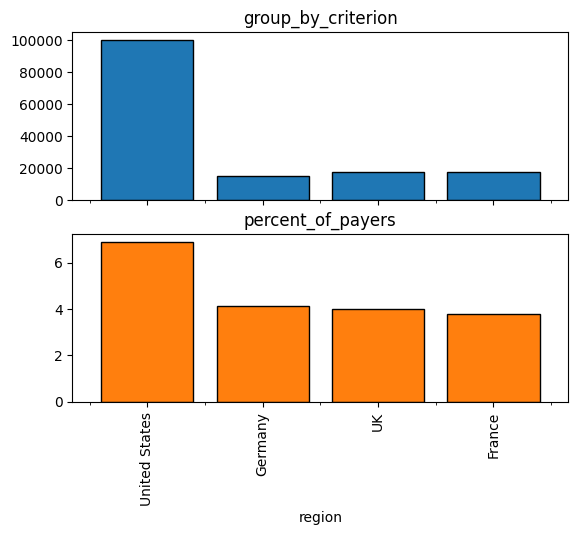

,group_by_criterion,percent_of_payers
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


In [19]:
#Посмотрим как выглядит общее число пользователей и % платящих из них
#в разных странах. Применим функцию profile_criterion.
prof_region = profile_criterion(['region'])
prof_region

**Вывод:**
Максимальное число привлеченных пользователей, как и процент платящих из них (6,9%), находятся в США. Значения для других стран находятся значительно ниже и примерно на одном уровне (около 4%).

### Устройства

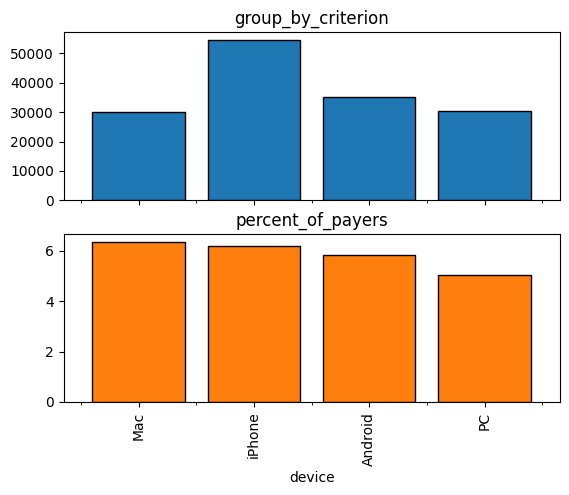

,group_by_criterion,percent_of_payers
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


In [20]:
#Посмотрим как выглядит общее число пользователей и % платящих из них
#для разных устройств. Применим функцию profile_criterion.
prof_device = profile_criterion(['device'])
prof_device

**Вывод:** Пользователи с айфонами - самая многочисленная группа. А процент платящих на 0,15% выше у пользователей Мас (6,21%). Наименьшей популярностью продукт пользуется у пользователей PC.

### Рекламные источники

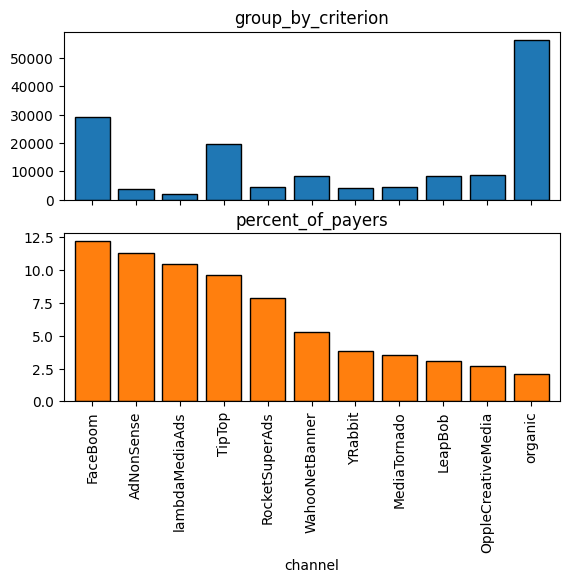

,group_by_criterion,percent_of_payers
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


In [21]:
#Посмотрим как выглядит общее число пользователей и % платящих из них
#для пользователей, пришедших с разных рекламных источников. Применим функцию profile_criterion.
prof_channel = profile_criterion(['channel'])
prof_channel

#### Рекламные источники

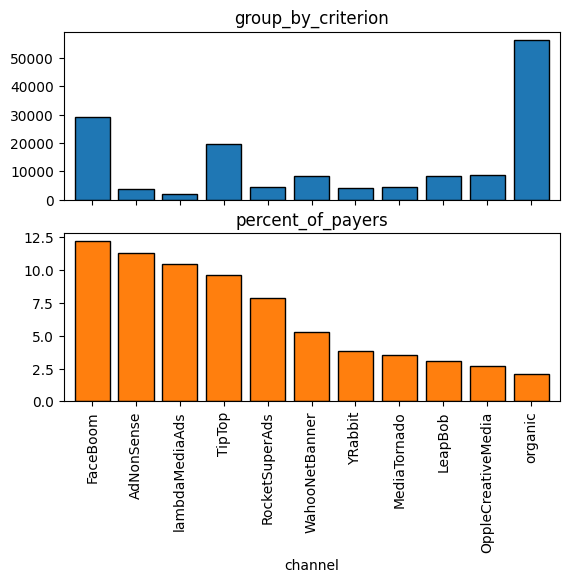

,group_by_criterion,percent_of_payers
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


In [22]:
#Посмотрим как выглядит общее число пользователей и % платящих из них
#для пользователей, пришедших с разных рекламных источников. Применим функцию profile_criterion.
prof_channel = profile_criterion(['channel'])
prof_channel

**Вывод:** В тройку лучших по привлечению пользователей входят: organic, FaceBoom и TipTop. А процент платящих "organic"-пользователей самый низкий - 2,06% (зато не было затрат на рекламу). Больше остальных платящих пользователей привлекает платформа FaceBoom (12,2%). Также в тройку входят AdNonSense и lambdaMediaAds. Платформа TipTop в этом рейтинге занимает 4ю позицию с 9,6% платящих.

**Вывод:** В тройку лучших по привлечению пользователей входят: organic, FaceBoom и TipTop. А процент платящих "organic"-пользователей самый низкий - 2,06% (зато не было затрат на рекламу). Больше остальных платящих пользователей привлекает платформа FaceBoom (12,2%). Также в тройку входят AdNonSense и lambdaMediaAds. Платформа TipTop в этом рейтинге занимает 4ю позицию с 9,6% платящих.

## Маркетинг

### Общие и конкретные расходы

In [23]:
#Рассчитаем общую сумму расходов на маркетинг по всем платформам.
cost_total = costs['costs'].sum()
print(f'Общая сумма расходов на маркетинг - {round(cost_total, 2)}.')

Общая сумма расходов на маркетинг - 105497.3.


,channel,costs,percent_of_total
0,TipTop,54751.30,51.90
1,FaceBoom,32445.60,30.75
2,WahooNetBanner,5151.00,4.88
3,AdNonSense,3911.25,3.71
4,OppleCreativeMedia,2151.25,2.04
5,RocketSuperAds,1833.00,1.74
6,LeapBob,1797.60,1.70
7,lambdaMediaAds,1557.60,1.48
8,MediaTornado,954.48,0.90
9,YRabbit,944.22,0.90


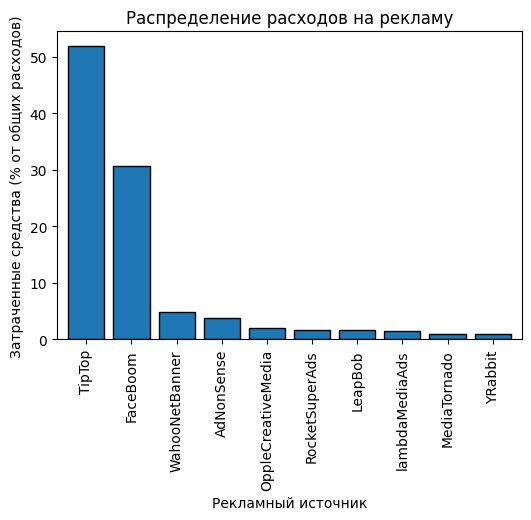

In [24]:
#Посмотрим суммарные расходы на каждую платформу по отдельности.
cost_for_channel = (costs
                    .groupby('channel')['costs'].sum()
                    .sort_values(ascending=False) #Отсортируем по убыванию расходов.
                    .reset_index() 
                   )
#Добавим столбец с относительными тратами на рекламу в % от общего для каждой платформы.
cost_for_channel['percent_of_total'] = round((cost_for_channel['costs']*100 / cost_total), 2) 

#Построим график для наглядности результатов.
cost_for_channel.plot(kind='bar',
                      x='channel',
                      y='percent_of_total',
                      width=0.8,
                      edgecolor='black',
                      legend=False,
                      figsize=(6,4))
plt.title('Распределение расходов на рекламу')
plt.xlabel('Рекламный источник')
plt.ylabel('Затраченные средства (% от общих расходов)');
#Выведем рекламные расходы в табличном виде.
cost_for_channel

*Комментарий.* Большое количество средств было вложено в рекламные источники TipTop (>54 тыс.) и FaceBoom (>32 тыс.), что суммарно составляет 82,5% от всех расходов. Расходы в остальные лежат в диапазоне от 944 до 5151.

### Расходы на рекламу в динамике

Визуализация динамики изменения расходов во времени:
По неделям:
Разбейте данные о расходах по неделям.
Постройте график, где по оси X будут недели, а по оси Y — сумма расходов.
Для каждого рекламного источника используйте отдельный цвет или линию на графике.
По месяцам:
Аналогично разбейте данные по месяцам.
Постройте аналогичный график с месяцами на оси X и суммой расходов на оси Y.

In [25]:
#Добавим информацию о неделях и месяцах из даты dt.
costs['event_week'] = costs['dt'].values.astype('datetime64[W]')
costs['event_month'] = costs['dt'].values.astype('datetime64[M]')
#Проверим результат.
costs.head()

,dt,channel,costs,event_week,event_month
0,2019-05-01,FaceBoom,113.3,2019-04-25,2019-05-01
1,2019-05-02,FaceBoom,78.1,2019-05-02,2019-05-01
2,2019-05-03,FaceBoom,85.8,2019-05-02,2019-05-01
3,2019-05-04,FaceBoom,136.4,2019-05-02,2019-05-01
4,2019-05-05,FaceBoom,122.1,2019-05-02,2019-05-01


In [26]:
#Определим функцию для создания сводной таблицы расходов по различным временным рамкам.
def dynamic_cost (event_time):
    costs_dynamic = (
        pd
        .pivot_table(data=costs,
                     index=event_time,
                     columns='channel',
                     values='costs',
                     aggfunc='sum')
    )
    return costs_dynamic

#Применим функцию для вычления информации о расходах и платформах по неделям и месяцам.
dynamic_week = dynamic_cost(['event_week'])
dynamic_month = dynamic_cost(['event_month'])

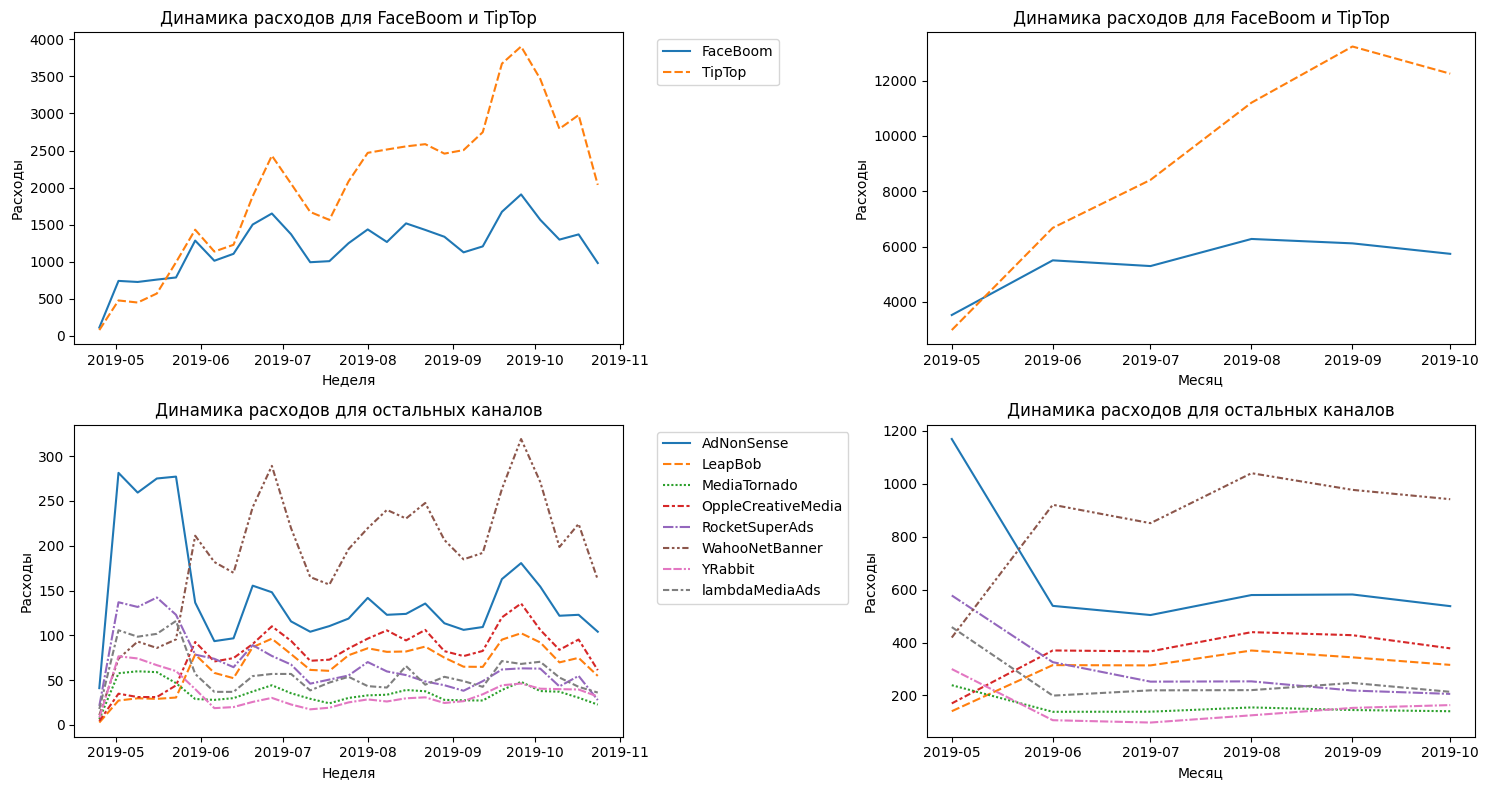

In [27]:
#Отобразим на графике данные из dynamic_week и dynamic_month.

#Имеет смысл для платформ 'FaceBoom' и 'TipTop' построить отдельные графики,
#т.к. на них суммарно приходится более 80% всех расходов.
#Выделим их в отдельную переменную.
big_costs_platforms = ['FaceBoom', 'TipTop']

#В таблице графиков — два столбца и две строки, четыре ячейки.
#Определим размер.
plt.figure(figsize=(15, 8))

#В первой строим график для 'FaceBoom' и 'TipTop' в рамках недель.
ax1 = plt.subplot(2, 2, 1)
sns.lineplot(data=dynamic_week[big_costs_platforms])
plt.title('Динамика расходов для FaceBoom и TipTop')
plt.ylabel('Расходы')
plt.xlabel('Неделя')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
#Bо второй ячейке строим график для 'FaceBoom' и 'TipTop' в рамках месяцев.
ax2 = plt.subplot(2, 2, 2)
sns.lineplot(data=dynamic_month[big_costs_platforms], ax=ax2, legend=False)
plt.title('Динамика расходов для FaceBoom и TipTop')
plt.xlabel('Месяц')
plt.ylabel('Расходы')

#В третьей - график для остальных каналов в рамках недель.
other_channels = dynamic_week.drop(['FaceBoom', 'TipTop'], axis=1)
ax3 = plt.subplot(2, 2, 3, sharex=ax1)
sns.lineplot(data=other_channels, ax=ax3)
plt.title('Динамика расходов для остальных каналов')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#В четвертой - график для остальных каналов в рамках месяцев.
other_channels = dynamic_month.drop(['FaceBoom', 'TipTop'], axis=1)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)
sns.lineplot(data=other_channels, ax=ax4, legend=False)
plt.title('Динамика расходов для остальных каналов')
plt.xlabel('Месяц')
plt.ylabel('Расходы')

plt.tight_layout()
plt.show()

*Комментарий.*
- Графики в разрезе недель для различных платформ имеют схожий ход. Отчетливо выделяются недели, на которых компания инвестировала в рекламу больше средств (пики появляются в одно время почти для всех платформ, начиная с июня).
- В разрезе месяцев наблюдается интенсивный рост инвестиций в TipTop и WahooNetBanner с течением времени (более, чем в 3  и 2 раза, соответственно). В рекламу на платформе AdNonSense наоборот, инвестиции резко снижаются в 2 раза и остаются примерно на одном уровне весь период исследования.
- В целом платформы можно разделить на 2 группы:
1) инвестиции в рекламу на которых снижаются с ко второму месяцу (июню), из представленных в данных и далее изменяются незначительно;
2) инвестиции в рекламу на которых, возрастают с течением времени.
- В последний месяц и несколько недель расходы на рекламу снизились по всем платформам.

### Стоимость привлечения одного пользователя (САС)

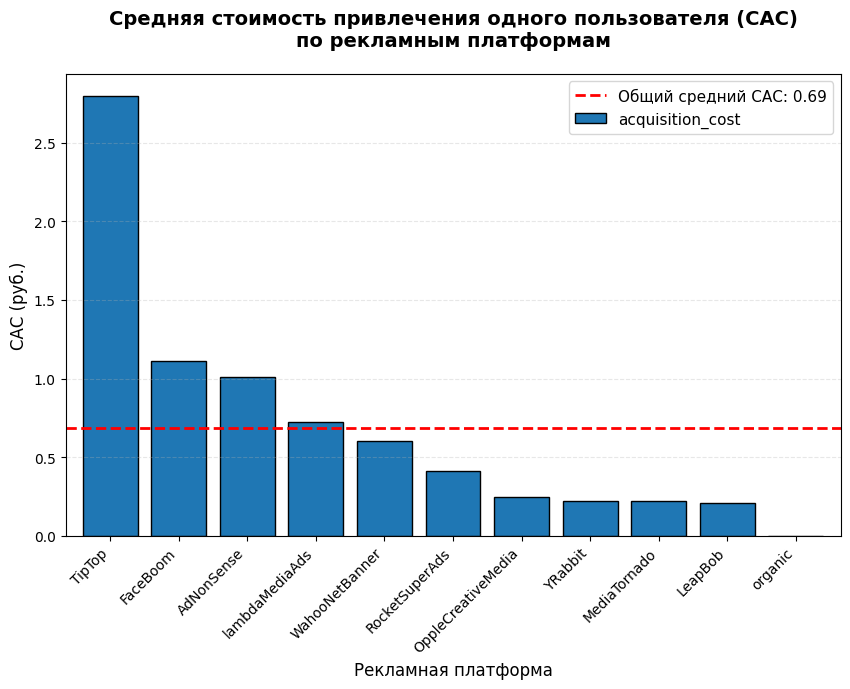

Средний САС по платформам:
channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

Общий средний САС: 0.69


In [45]:
#Для рассчета САС воспользуемcz таблицей profiles.

#Рассчитываем средний САС по рекламным источникам.
platform_cac = (
    profiles
    .groupby('channel')['acquisition_cost']
    .mean()
    .sort_values(ascending=False)
)

#Создаем график.
fig, ax = plt.subplots(figsize=(10, 6))

platform_cac.plot(
    kind='bar',
    ax=ax,
    width=0.8,
    edgecolor='black',
)

#Добавляем горизонтальную линию общего среднего САС.
overall_mean_cac = platform_cac.mean()
ax.axhline(
    y=overall_mean_cac,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Общий средний САС: {overall_mean_cac:.2f}'
)

plt.title(
    'Средняя стоимость привлечения одного пользователя (САС)\n'
    'по рекламным платформам',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.xlabel('Рекламная платформа', fontsize=12)
plt.ylabel('САС (руб.)', fontsize=12)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.show()

#Выводим табличные данные.
print("Средний САС по платформам:")
print(platform_cac)
print(f"\nОбщий средний САС: {overall_mean_cac:.2f}")

*Комментарий.* Стоимость привлечения одного клиента через платформу TipTop превышает аналогичную характеристику для других платформ более чем в 2,5 раза. САС 'organic'-клиента, очевидно, равна 0. Средняя стоимость привлечения клиента с других рекламных платформ стоила от 0,21 до 1,11. Общий средний САС составил 0,69. Это значение превышено для таких платформ как TipTop, FaceBoom, AdNonSense. Для платформы lambdaMediaAds значение САС незначительно превышет 0,69 и составляет 0,72. САС отальных платформ находится ниже общего среднего.

### Промежуточный вывод

- Наибольшее внимание компания уделяет двум рекламным платформам: FaceBoom и TipTop.Средние расходы на эти платформы составляют более 80% от всех затрат на рекламу. Особенно наращиваются инвестиции на платформе TipTop. При этом САС для нее самый высокий - 2,8.
- По САС ситуация с FaceBoom выглядит намного лучше - 1,1. Такие же показатели у AdNonSense - 1,0, а сумма вложений в 6 раз меньше и была резко снижена с июня.
- В целом платформы можно разделить на 2 группы:
1) инвестиции в рекламу на которых снижаются с ко второму месяцу (июню), из представленных в данных и далее изменяются незначительно;
2) инвестиции в рекламу на которых, возрастают с течением времени.
- В последний месяц и несколько недель расходы на рекламу снизились по всем платформам.
- Похоже, что компания выделяет различное количество средств на рекламу каждую неделю. В рамках недель, когда затраты увелчиивались, они возрастали сразу на всех платформах. Возможно, с июня появилась конкретная стратегия продвижения продукта через рекламу на конкретных платформах.

## Окупаемость рекламы

### Момент и горизонт анализа данных

In [29]:
observation_date = datetime(2019, 7, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

### Окупаемость рекламы

Используя определенные ранее функции, построим графики для анализа окупаемости рекламы.

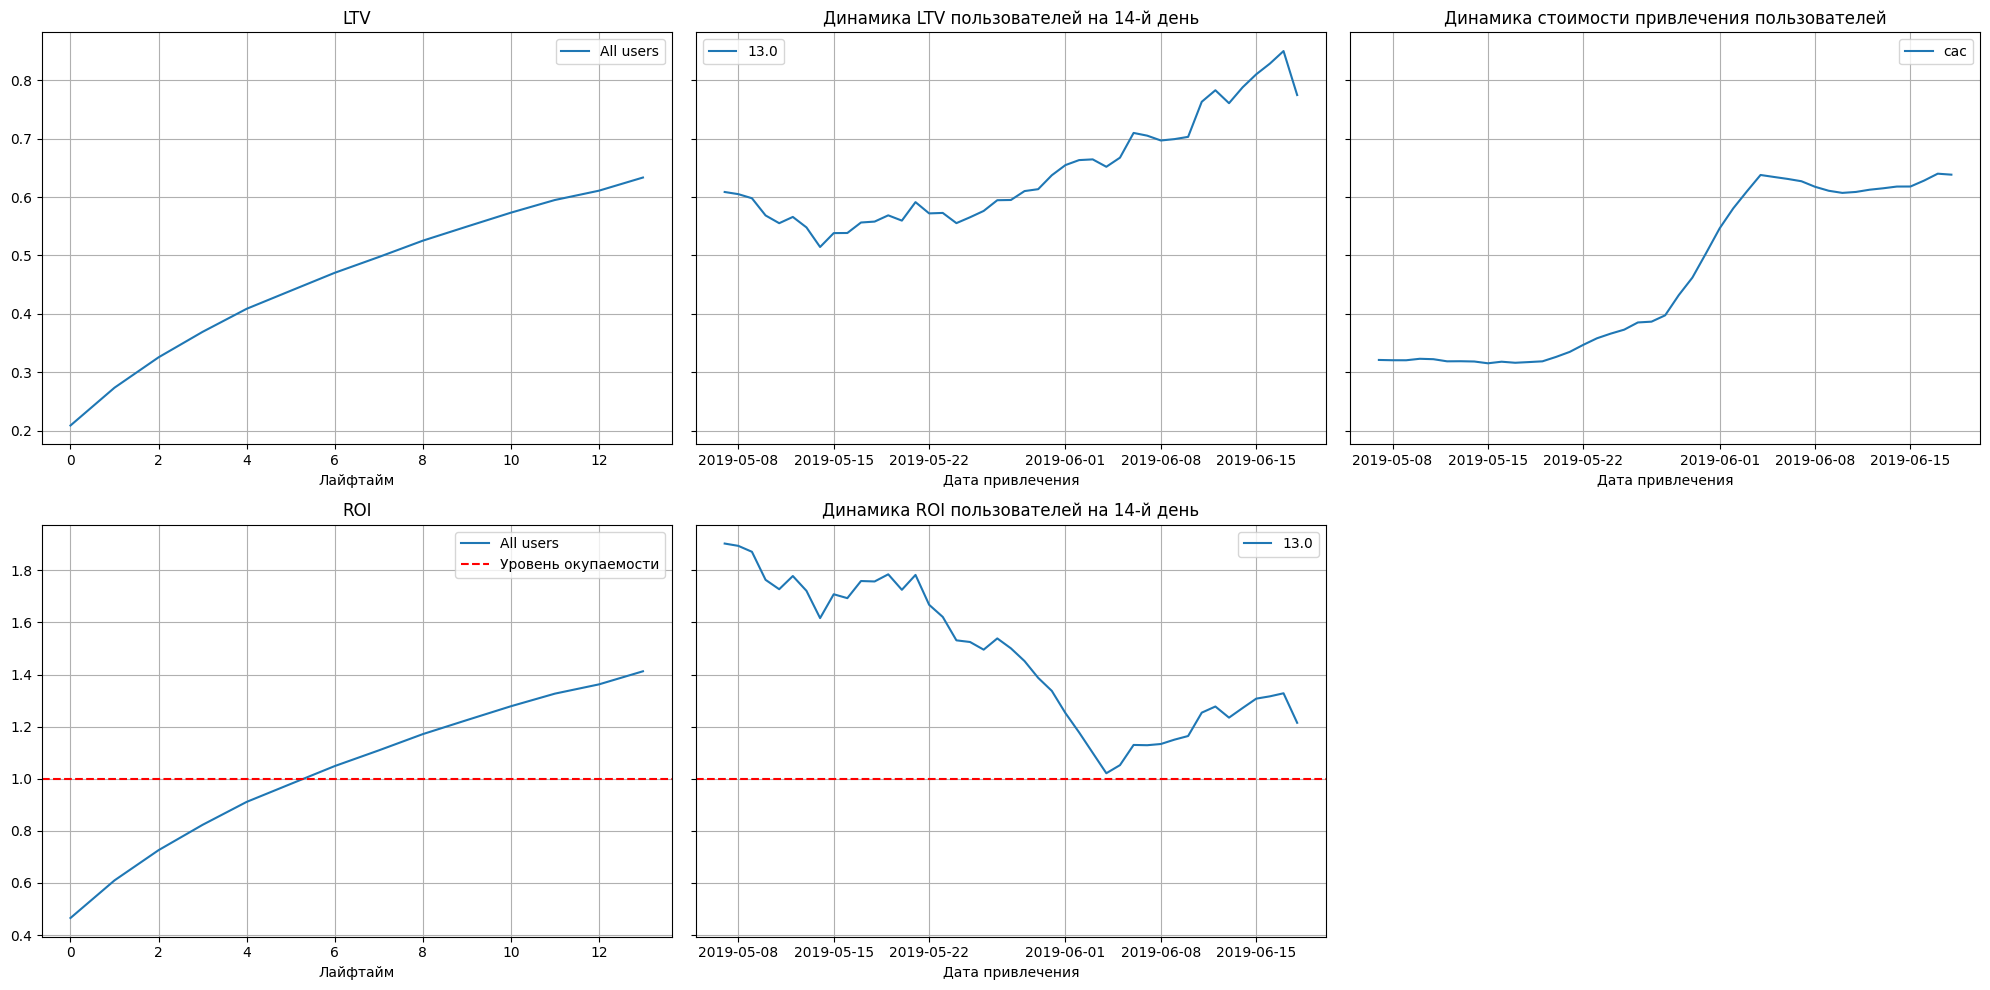

In [30]:
#LTV и ROI.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

#Построим графики, в т.ч. посмотрим динамику.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

*Комментарий.*
- Согласно графикам, реклама окуппается на 5й день "жизни" пользователей. ROI выше окупаемости, есть тенценция к снижению.
- САС значительно увеличился для пользователей, привлеченных после 18 мая, а ROI пошел на снижение. Достиг пика примерно лдя привлеченных 3 июля, в то же время ROI достиг минимума.
- LTV в динамике стабильно растет.

### Конверсия и удержание

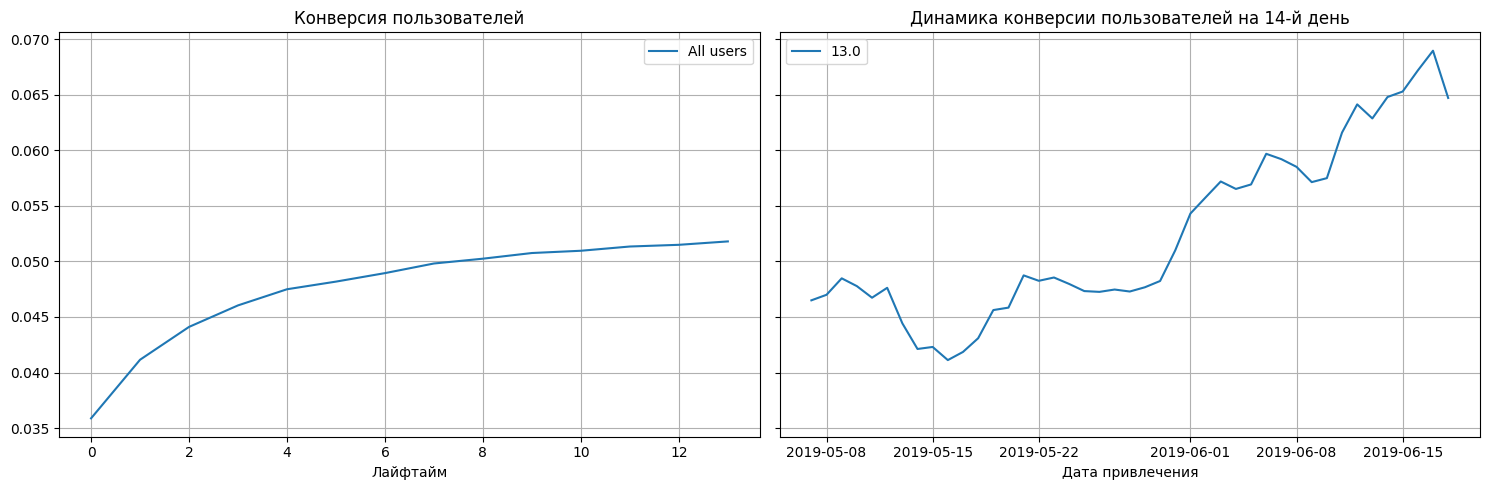

In [31]:
#Посмотрим конверсию.
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

*Комментарий.*
- Конверсия с увеличением лайфтайма растет и на 14й день составляет примерно 0,052 при начальной в первый день "жизни" 0,036. Кривая растет экспоненциально.
- Конверсия пользователей, привлеченных до 16 мая снижалась, после - увеличивалась и достигла максимума (0,068) на 13й день, на 14й день снизилась до 0,065.

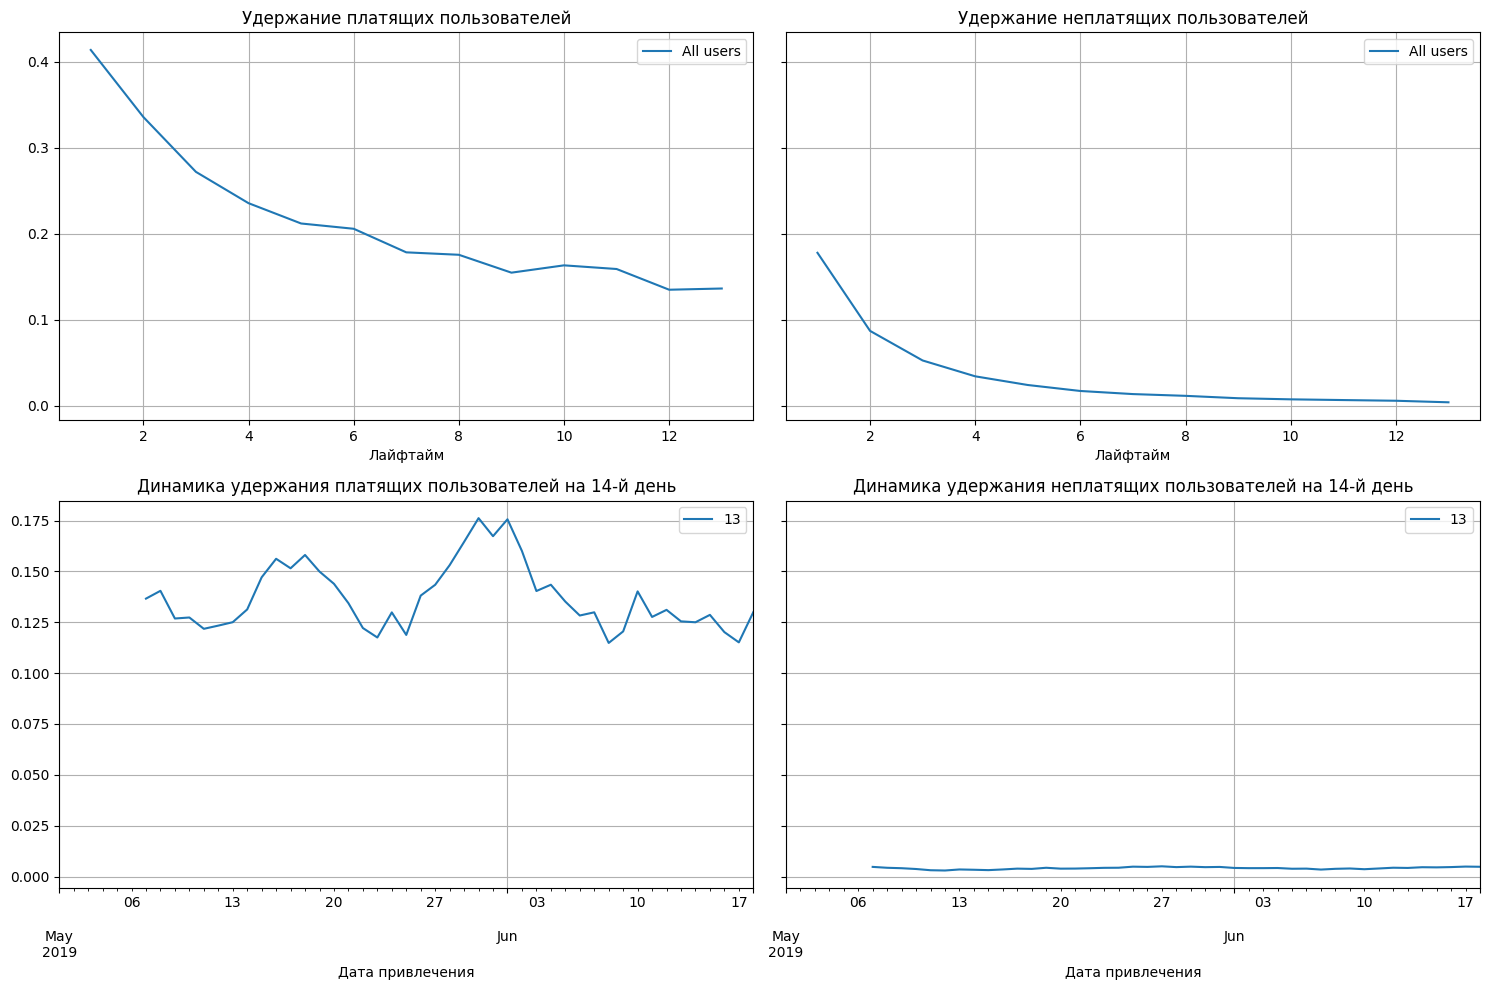

In [32]:
#Посмотрим удержание.
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

*Комментарий.*
- Удержание платящих пользователей в несколько раз выше неплатящих. В целом удержание всех пользователей экспоненциально снижается. В случае неплатящих к 14 дню удержание приближается близко к 0.
- Динамика удержания платящих пользователей в целом постоянна и незначительно отличается в первый и последний из расссматриваемых дней. Для неплатящих - не изменяется и близка к 0.

#### Конверсия и удержание по устройствам

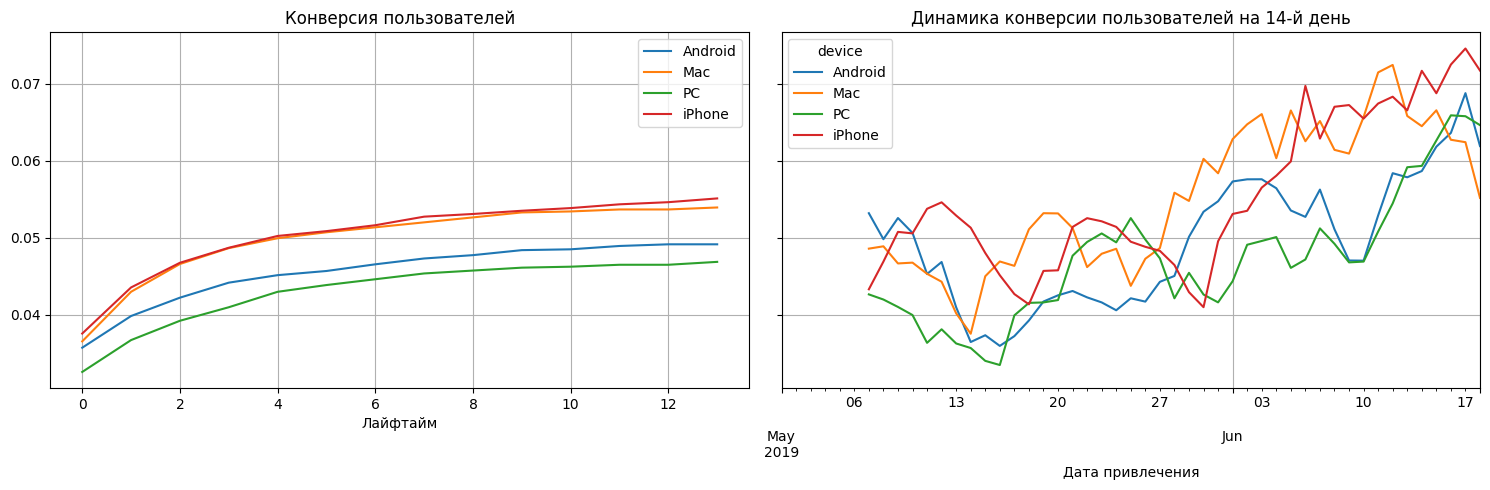

In [33]:
#Посмотрим конверсию для пользователей различных устройств.
#Зададим признак, по которому разделим пользователей.
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

*Комментарий.*
- Пользователи iPhone и Mac конвертируются одинаково и лучше пользователей, с Android и PC. Минимальная конверсия для пользователей PC.
- В динамике конверсия пользователей всех устройств на 14й день возрастает с течением времени.

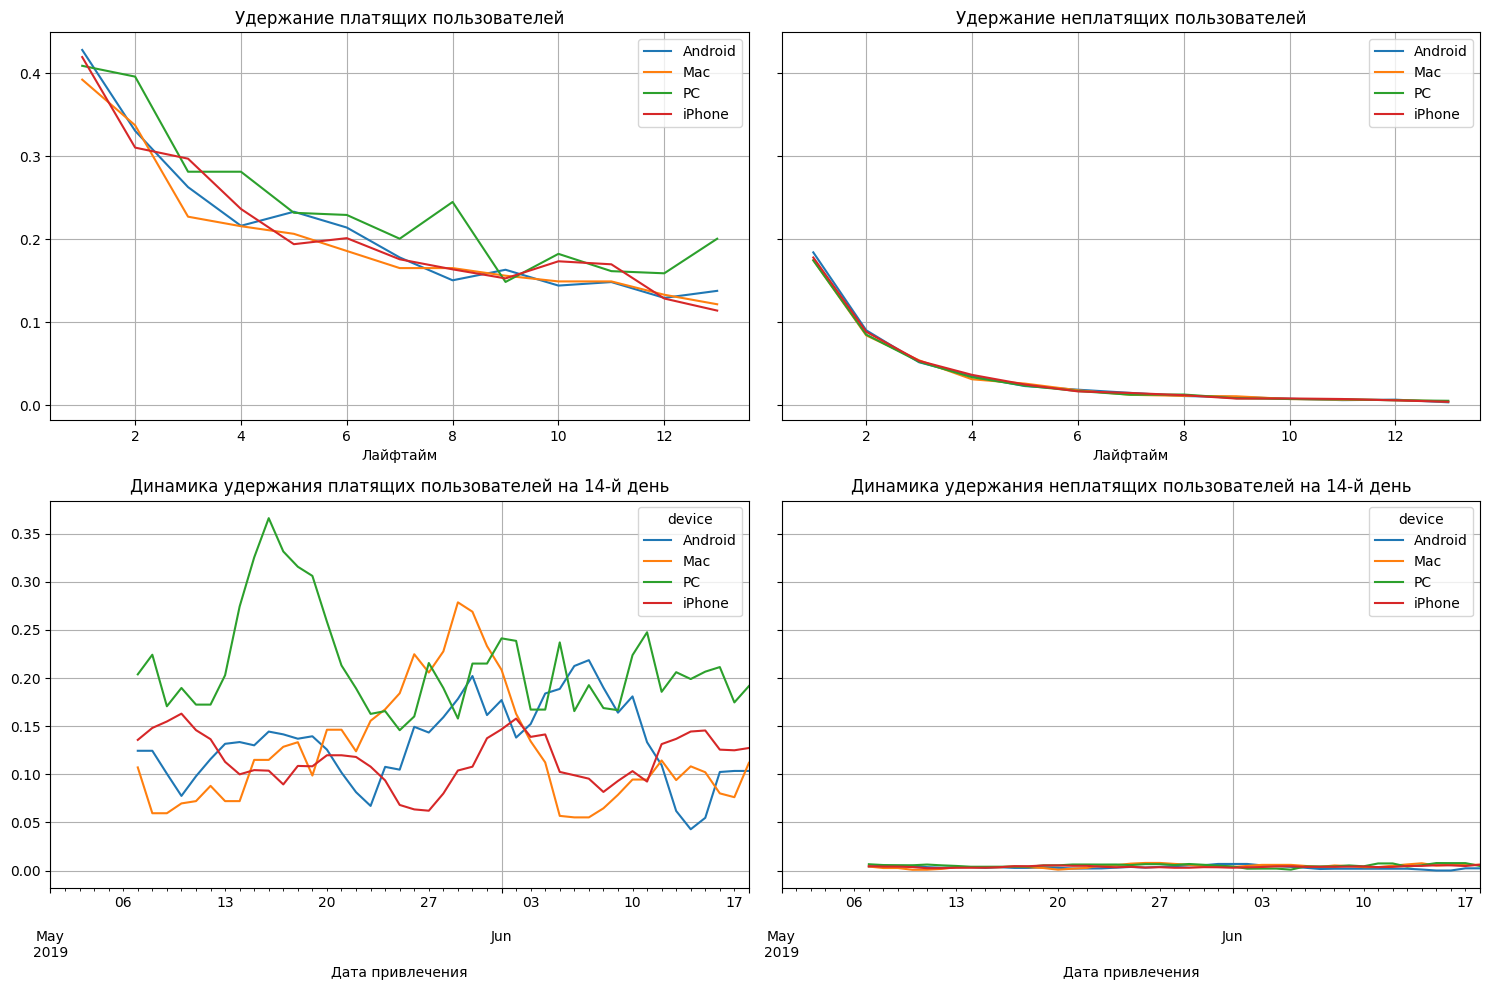

In [34]:
#Посмотрим удержание пользователей различных устройств.
#Зададим признак, по которому разделим пользователей.
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

*Комментарий.*
- Платящие пользователи удерживаются лучше неплатящих.
- Среди пользователей выделяются с устройством PC. На 8й день их удержание заметно возрастает и на 14й день соотвествует 7му.
- Удержание пользователей PC, привлеченных 15 мая на 42% выше, чем других.

#### Конверсия и удержание по странам

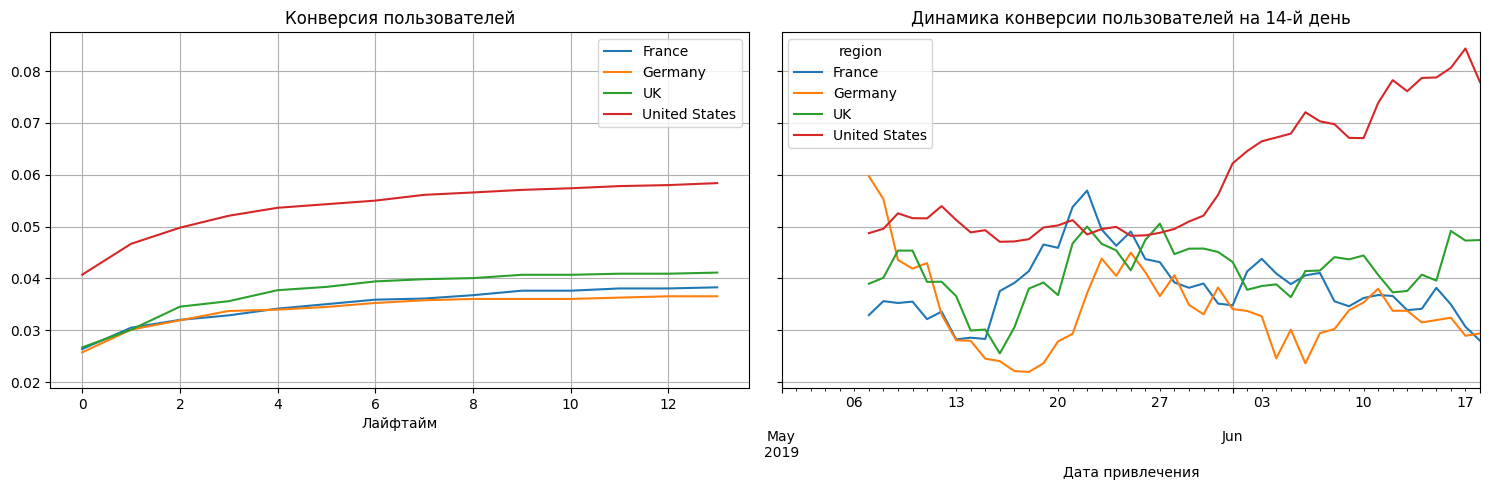

In [35]:
#Посмотрим конверсию для пользователей из разных стран.
#Зададим признак, по которому разделим пользователей.
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

*Комментарий.*
- Пользователи из США конвертируются намного лучше остальных, конверсия остальных примерно одинакова.
- В динамике конверсия пользователей из США увеличивается после 27 июля, для других стран этот показатель в этот период стабилен в среднем. Ход кривых для Германии, США и Великобритании имеет один характер.

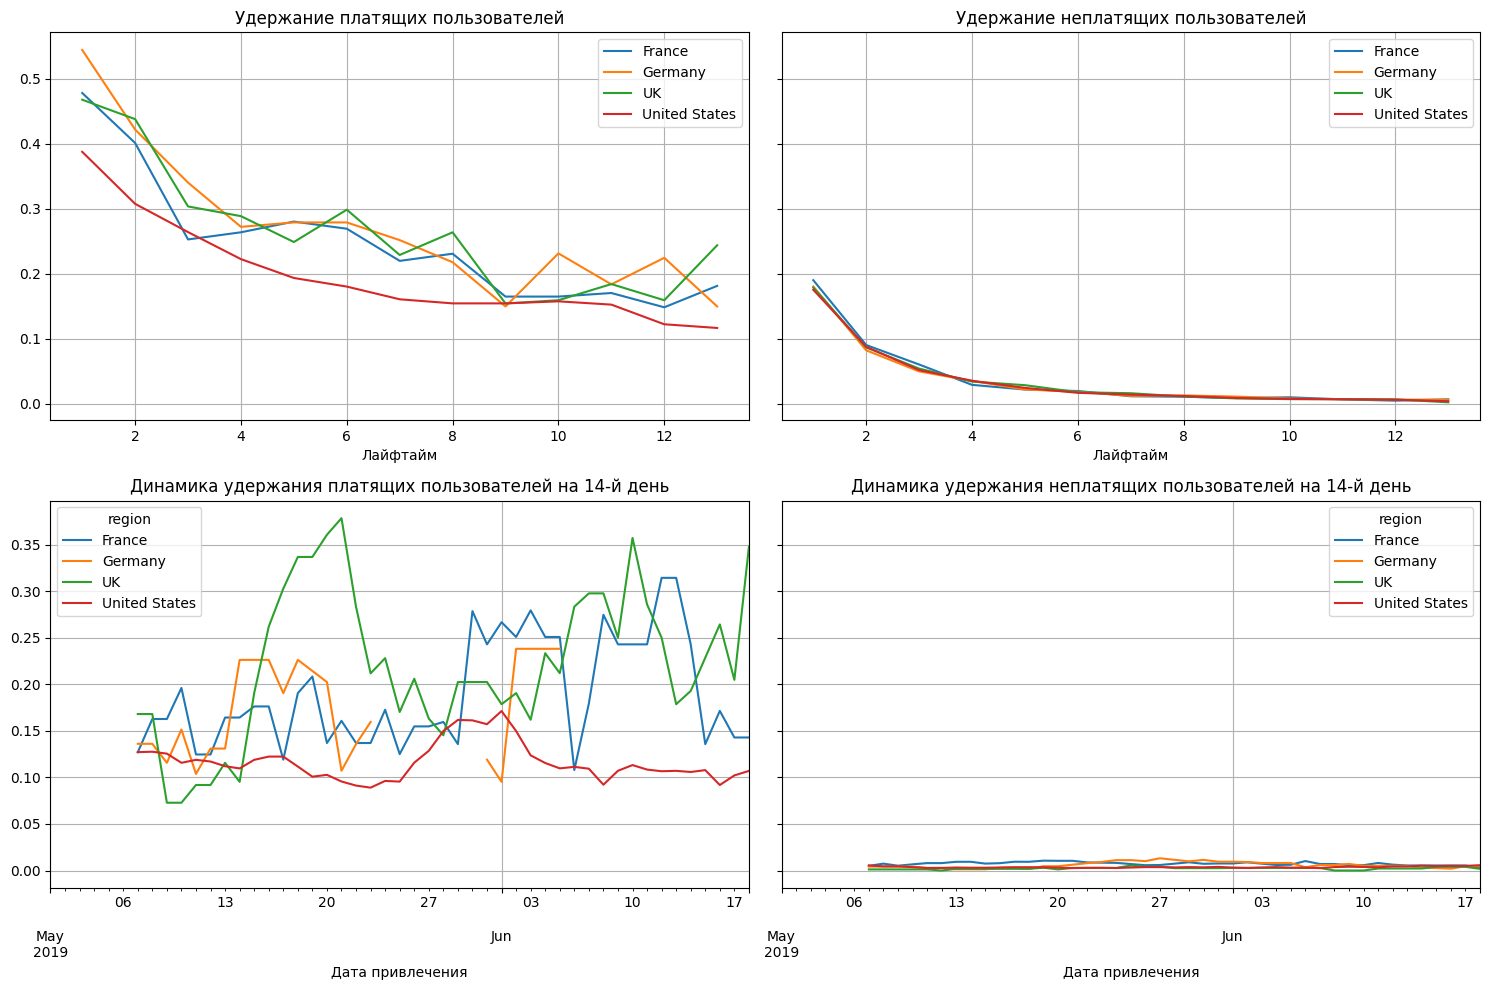

In [36]:
#Посмотрим удержание пользователей из разных стран.
#Зададим признак, по которому разделим пользователей.
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

*Комментарий.*
- Платящие пользователи удерживаются лучше неплатящих.
- Платящие пользователи из США хотя и показывают высокую конверсию, удерживаются хуже остальных.
- Интересен участок кривой для пользователей, привлеченных 14-21 мая: их удержание резко выросло и на пике составило 0,37.
- Согласно графику удержания в динамике, пользователи из Германии, "прожившие" 2 недели, были привлечены только в периоды с 6 по 24 мая и с 31 мая по 5 июля.

In [37]:
#Для проверки предположения о пользователях из Германии изучим таблицу удержания в числах.
#Вызовем для Германии описание данных 14го дня и столбца с размером "платящих" когорт.
retention_history.query('region == "Germany" and payer == True')[['cohort_size', 13]].reset_index().describe()

,cohort_size,13
count,46.000000,46.000000
mean,3.195652,0.151863
std,1.771623,0.231365
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,0.250000
max,7.000000,1.000000


*Комментарий.* Отсутствующие значения для Германии связаны с тем, что пользователи не "доживали" до 14 дней: 75% данных представлены нулевым значением. Проблема, вероятно, связана с размером выборки (когорты): 25% значений меньше 3, минимальное - 1. Это объясняет, почему пользователи, привлеченные в некоторые даты не остаются активными 2 недели. По таким данным нельзя достоверно оценить удержание пользователей.

#### Конверсия и удержание по платформам

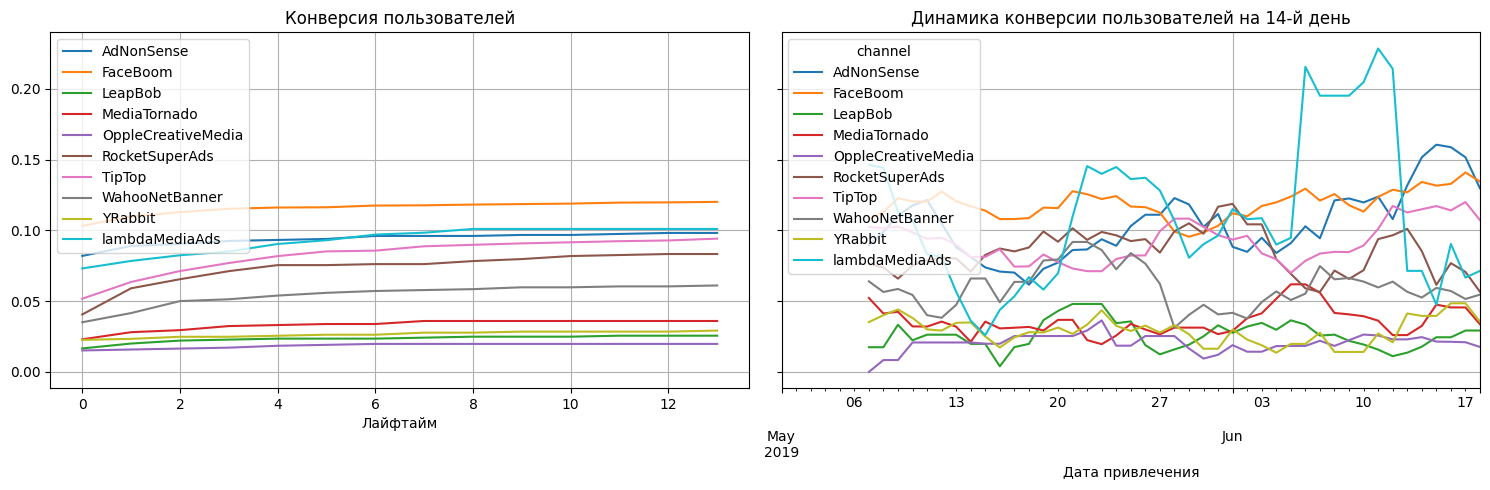

In [38]:
#Посмотрим конверсию для пользователей, привлеченных с разных платформ.
#Исключим 'organic'-пользователей.
#Зададим признак, по которому разделим пользователей.
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

*Комментарий.*
- Топ-3 платформ по конверсиии пользователей в порядке убывания показателя: 1) FaceBoom, 2) примерно одинаковы AdNonSense и lambdaMediaAds, 3) TipTop.
- В динамике конверсия пользователей всех устройств на 14й день в целом не меняется с течением времени. Выбивается толькоо кривая платформы lambdaMediaAds, для которой резко возрастает конверсия пользователей привлеченных с 4 июня по 12 июня, после чего резко снижается. 

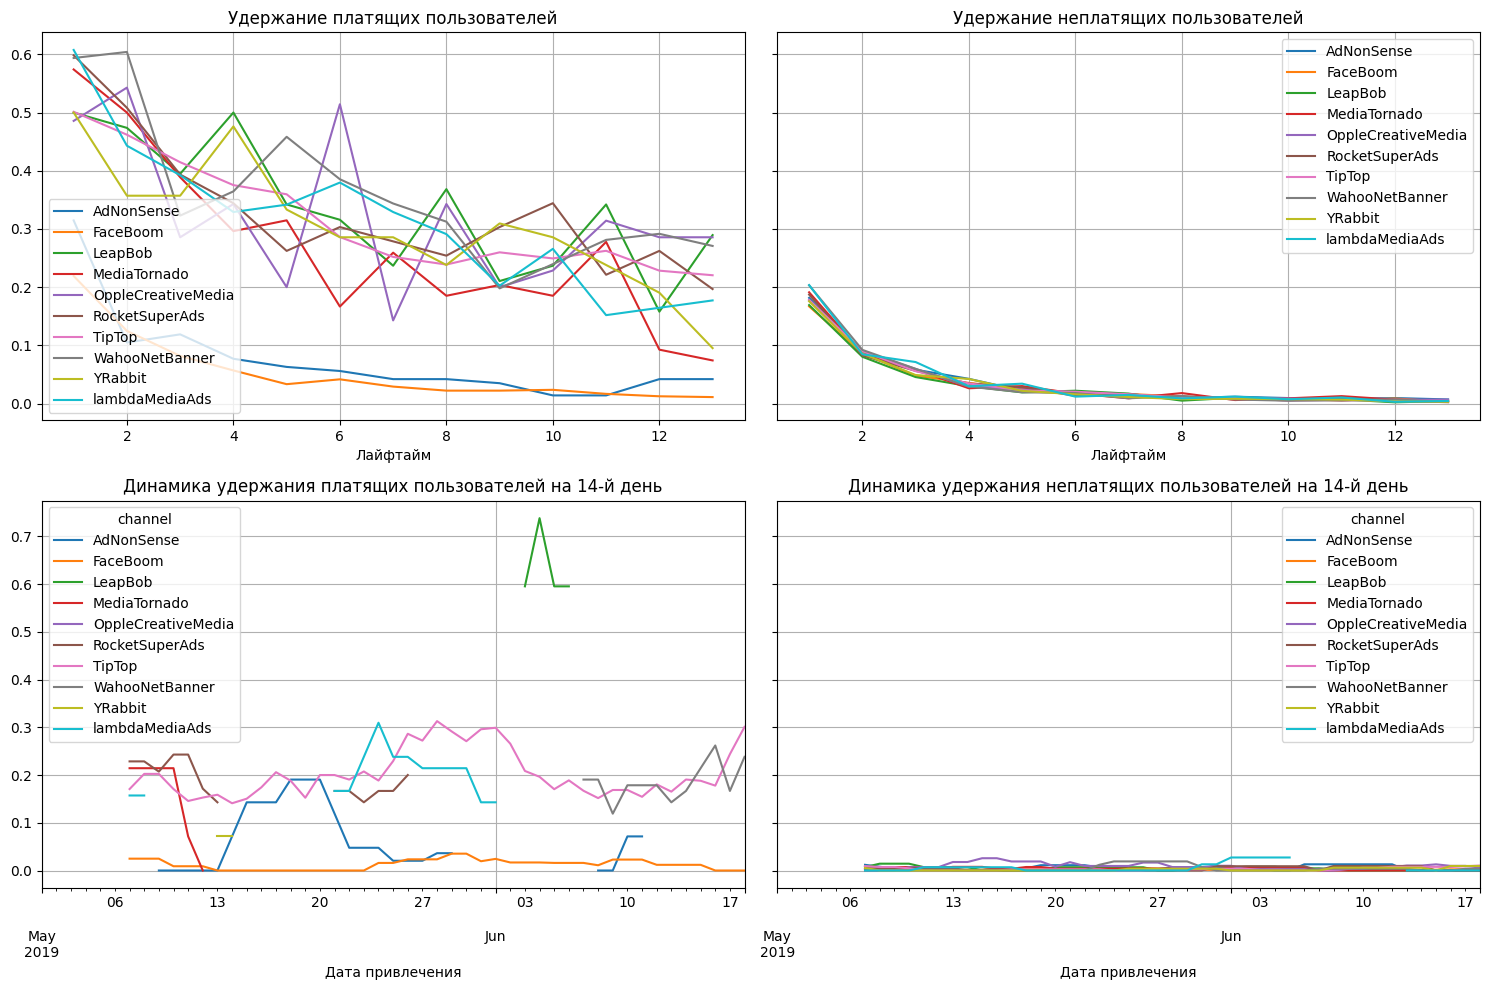

In [39]:
#Посмотрим удержание пользователей, привлеченных с разных платформ.
#Исключим 'organic'-пользователей.
#Зададим признак, по которому разделим пользователей.
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['channel'] != 'organic'], visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

*Комментарий.*
- Платящие пользователи удерживаются лучше неплатящих.
- В динамике видим рваные кривые. Это говорит об отсутствии пользователей из когорты, соответствующих платформы и даты привлечения, на 14й день. Информация за весь исследуемый период доступна только по двум рекламным платформам: FaceBoom и TipTop. Удержание пользователей, пришедших через TipTop, в среднем - 0,2. Для пришедших через FaceBoom удержание очень низкое и близкое к нулю.

In [40]:
#Изучим таблицу удержания в числах.
#Вызовем для всех платформ, кроме Faceboob и TipTop описание данных 14го дня
#и столбца с размером "платящих" когорт.
(
    retention_history
    .query('channel != "FaceBoob" and channel != "TipTop" and payer == True')[['cohort_size', 13]]
    .reset_index().describe()
)

,cohort_size,13
count,324.000000,324.000000
mean,4.104938,0.140543
std,5.266999,0.279224
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,4.000000,0.111111
max,31.000000,1.000000


*Комментарий.* Ситуация с удержанными пользователями очень грустная по той же причине, что и для Германии - когорты, размер котрых не превышает 4х человек составлют 75% от всех данных. Такие данные нельзя считать информативными для оценки пользовательской активности либо рекламы эффективными.

### Окупаемость рекламы по устройствам

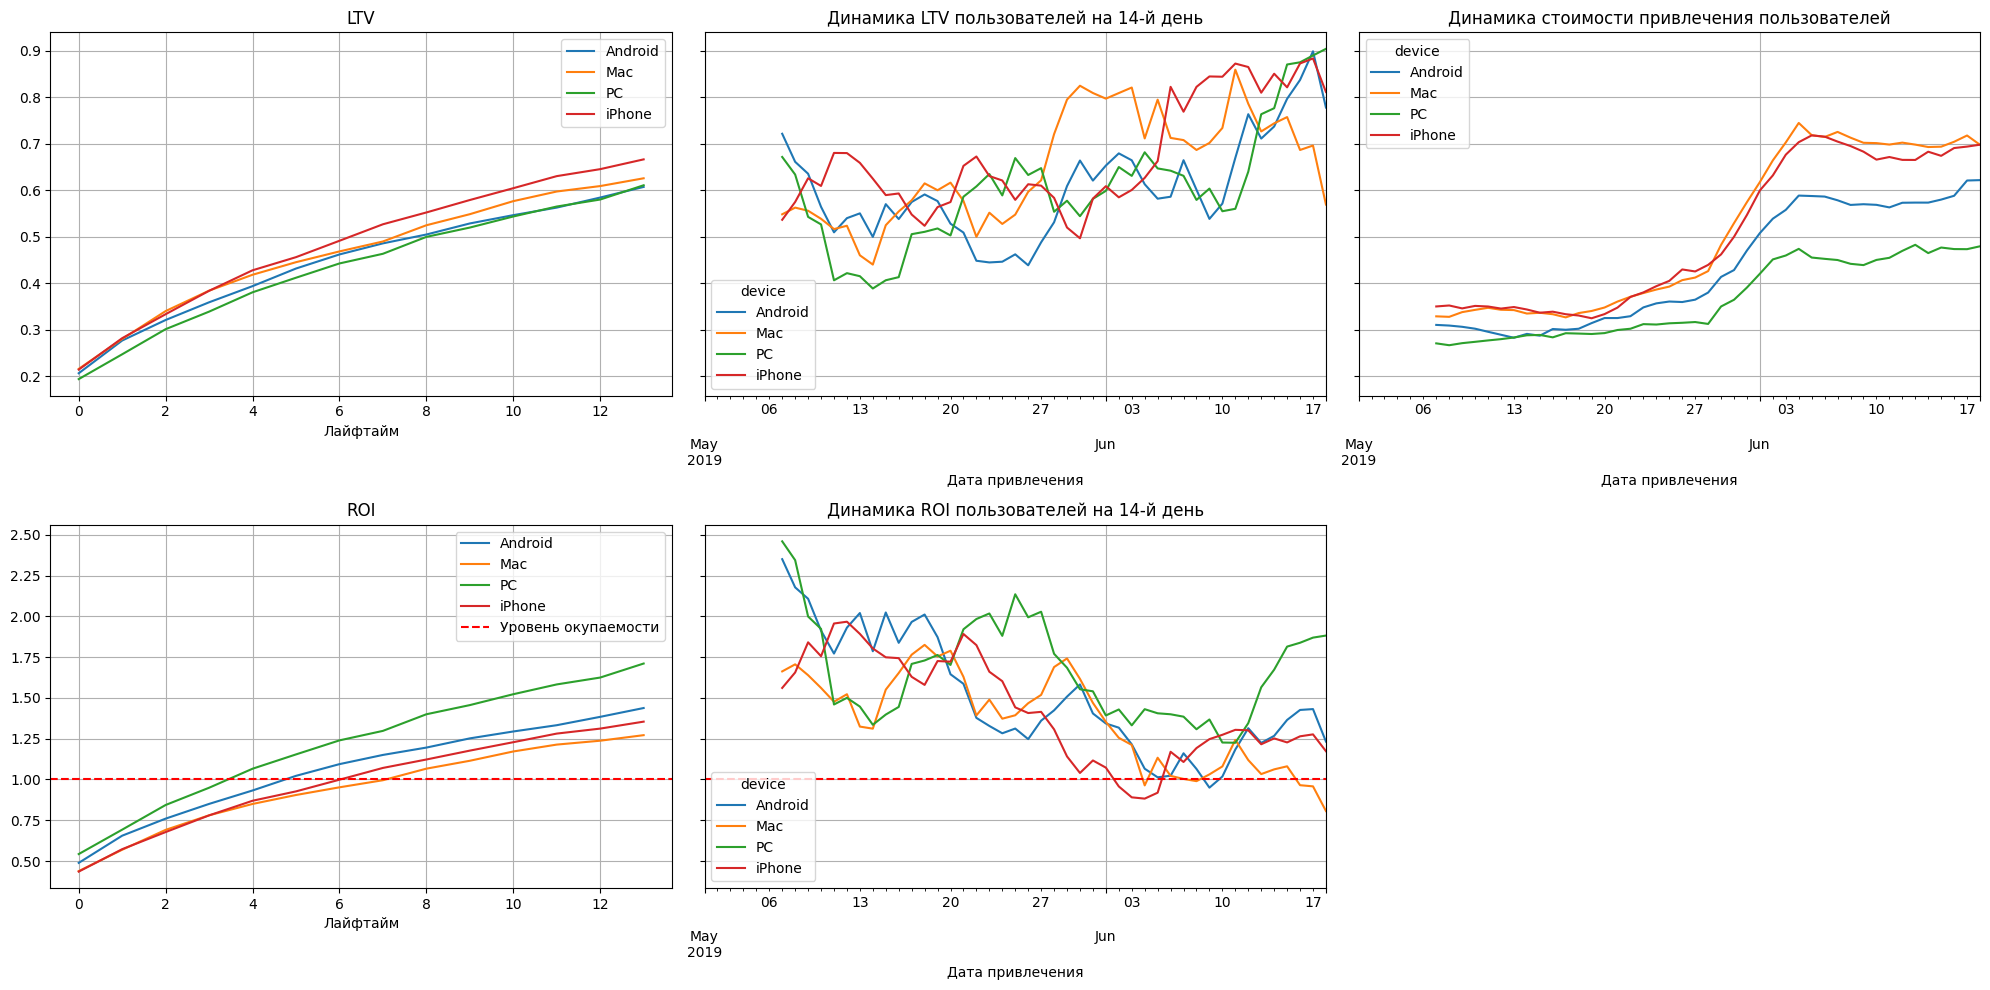

In [41]:
#Зададим признак, по которому разделим пользователей.
#LTV и ROI.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

#Построим графики, в т.ч. посмотрим динамику.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

*Комментарий.*
- LTV по лайфтайму и в динамике растет.
- Среди пользователей, привлеченных после 27 мая по 5 июня, наблюдается резкий рост САС. Самый низкий САС у PC, самый высокий - у Mac и iPhone.
- Все утсройства окупаются за неделю. Бысьрее всего - PC за 3 дня, хуже всего - MAС за 7 дней.
- Динамика ROI: в целом наблюдается тенденция к снижению. В последнее время лучше всего показатели были у PC.

### Окупаемость рекламы по странам

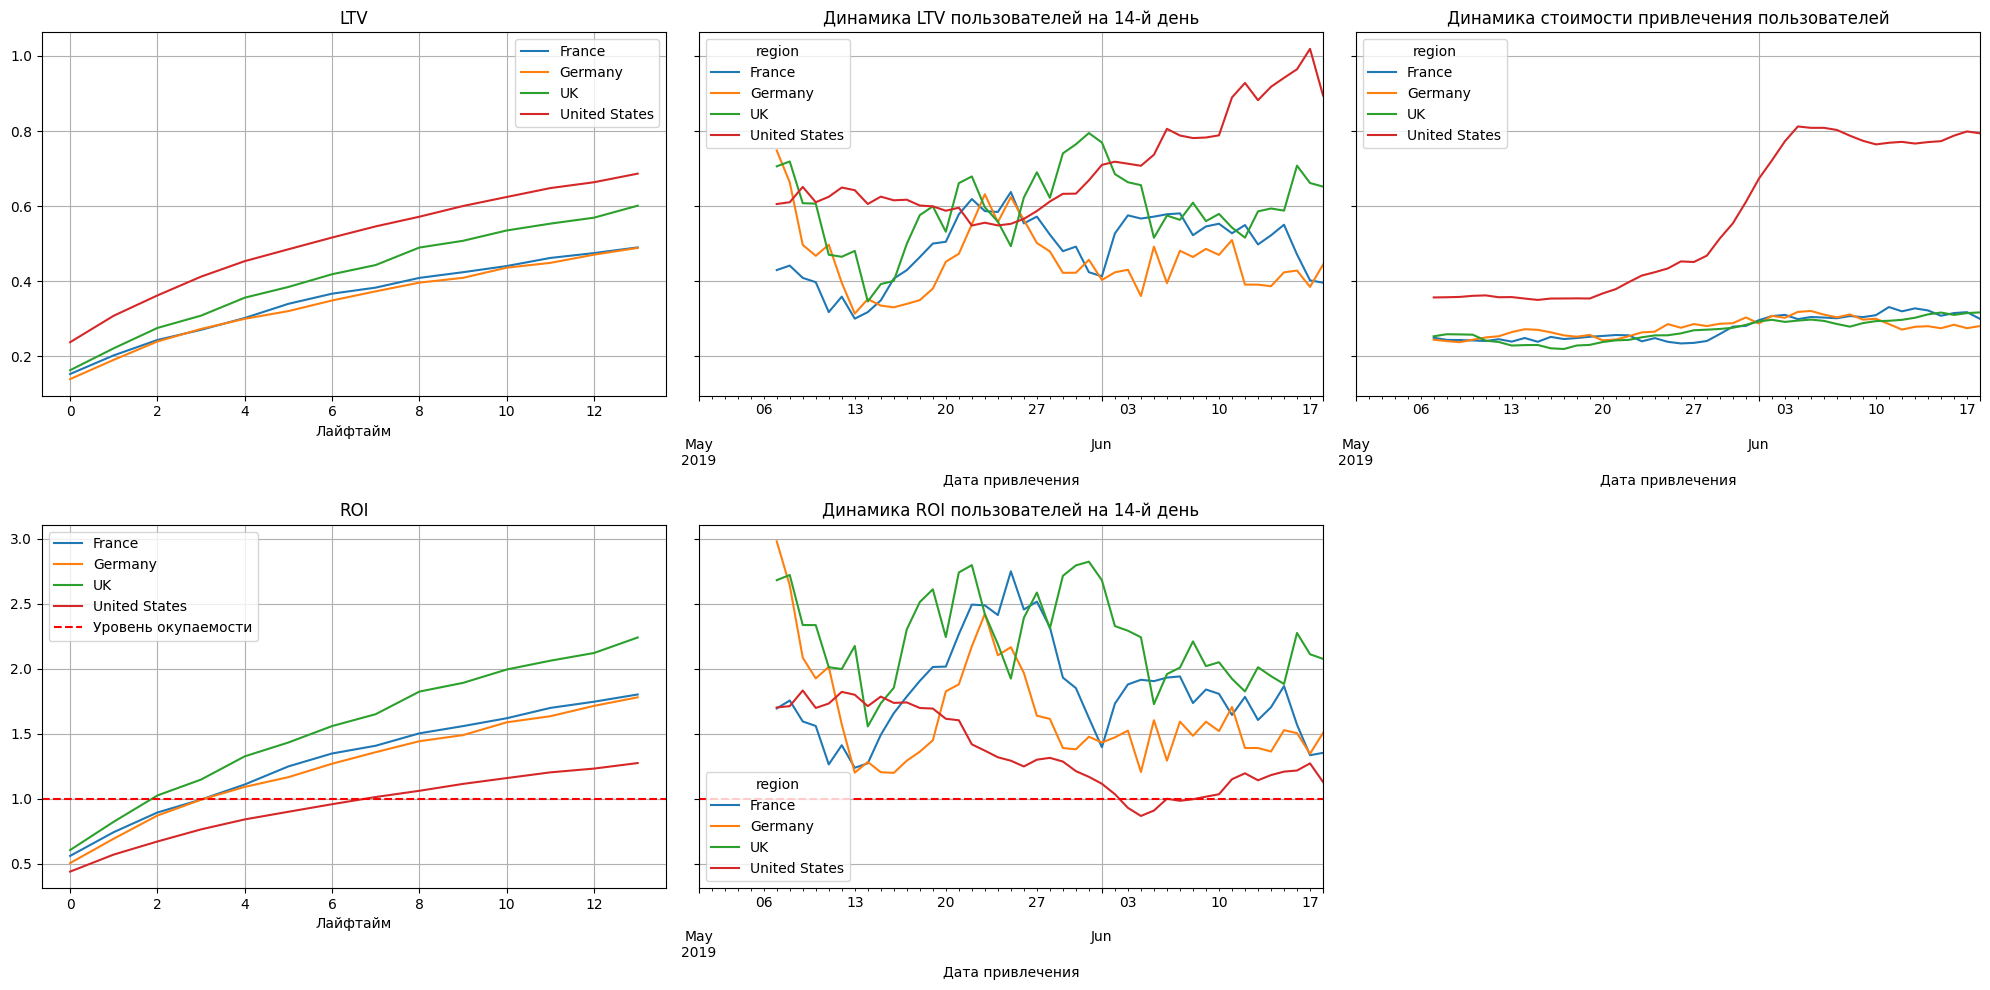

In [42]:
#Зададим признак, по которому разделим пользователей.
#LTV и ROI.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

#Построим графики, в т.ч. посмотрим динамику.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

*Комментарий.*
- LTV по странам растет. В динамике находится примерно на одном уровне для всех стран, кроме США. Для США растет в последние дни привлечения из анализируемого промежутка времени.
- Среди пользователей из США, привлеченных после 20 мая по 5 июня, наблюдается резкий рост САС. У остальныхх в разы ниже и примерно равен между собой.
- Реклама во всех странах окупается в пределах недели: быстре всего в Великобритании (2 дня), медленее - в США (7 дней).
- Динамика ROI: в целом остается постоянным. Лучше всего показатели были у PC, хуже - у США.

### Окупаемость рекламы по платформам

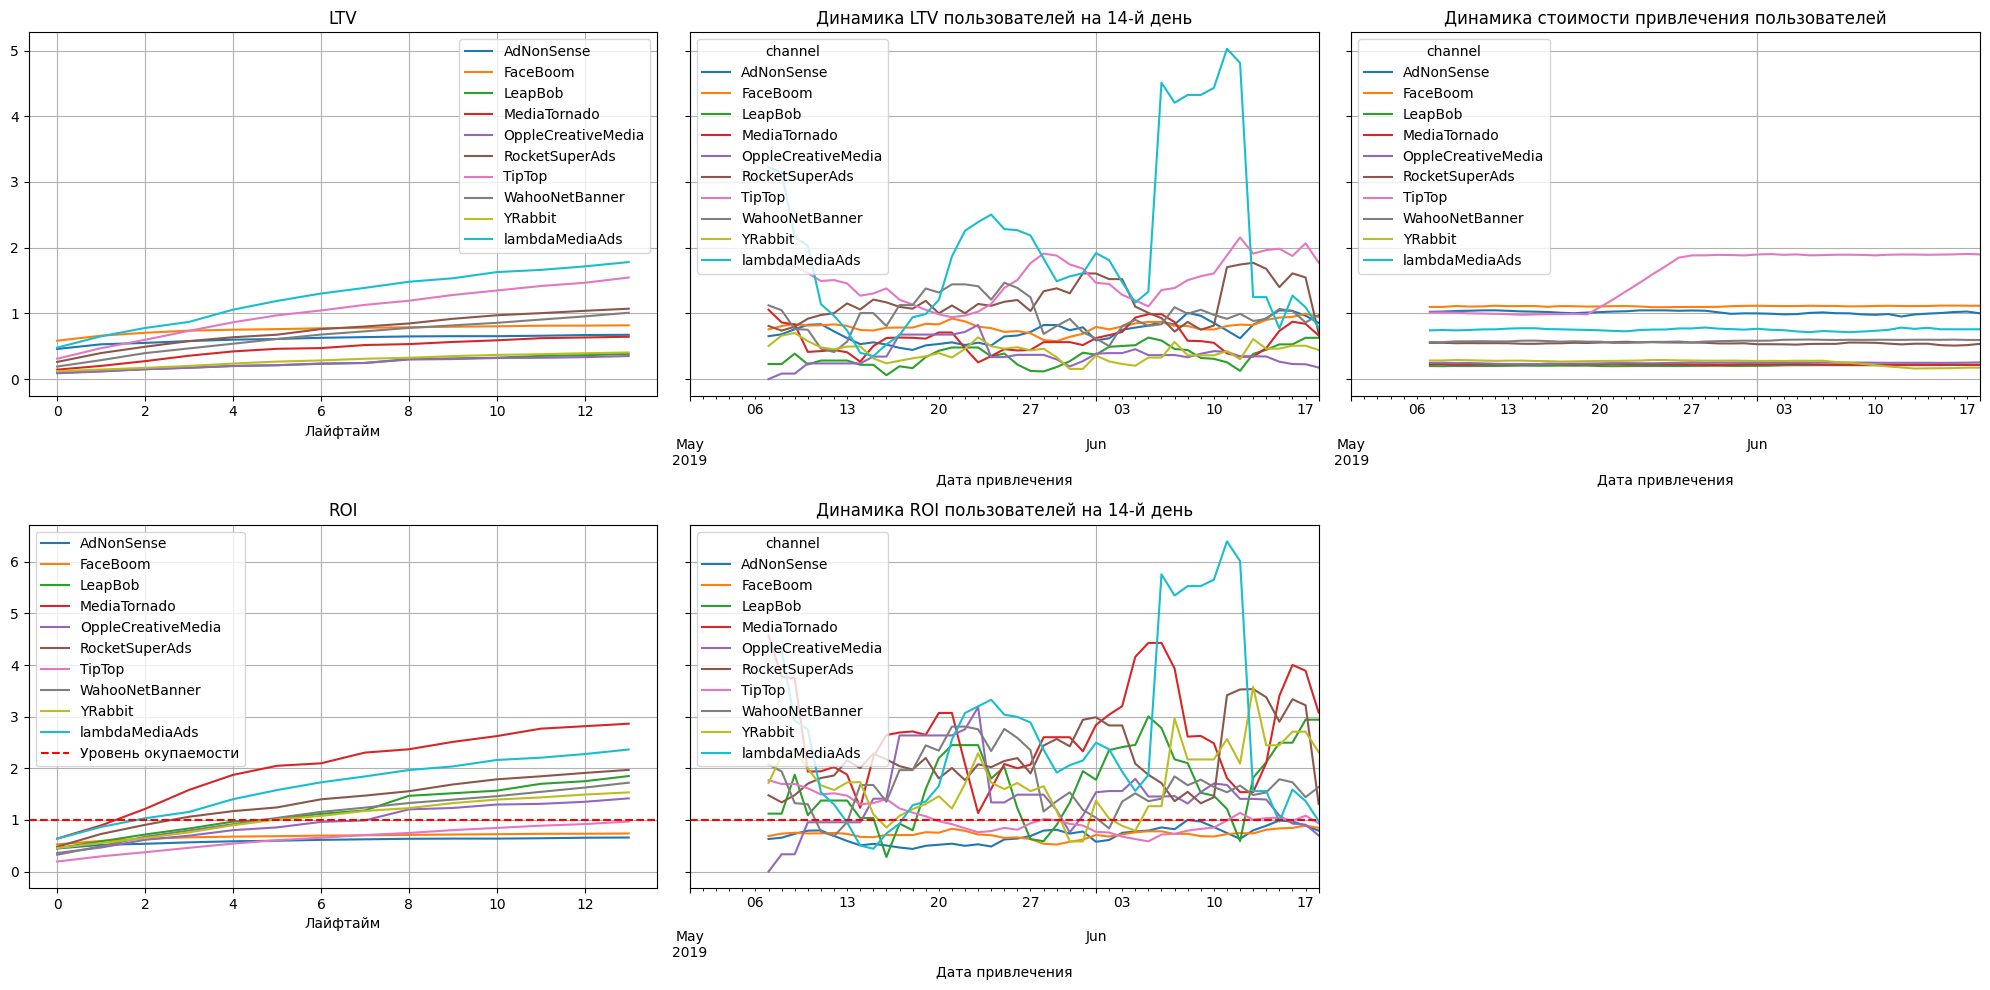

In [43]:
#Зададим признак, по которому разделим пользователей.
#Исключим 'organic'-пользователей.
#LTV и ROI.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel']
)

#Построим графики, в т.ч. посмотрим динамику.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

*Комментарий.*
- LTV по платформам растет. Выделяются по высокому LTV lambdaMediaAds и TipTop. В динамике остается примерно на одном уровне.
- Среди пользователей, привлеченных с платформы TipTop после 20 мая по 27 мая, наблюдается резкий рост САС. Для остальных платформ САС не зависит от даты привлечения.
- Не окупается реклама на трех платформах: TipTop, FaceBoom, AdNonSence.
- Динамика ROI: в целом без изменений. В июне у платформ lambdaMediaAds, MediaTornado наблюдаются скачки роста ROI.

### Промежуточные выводы

- Реклама, направленная на привлечение пользователей в целом, окупается на 5 день "жизни" пользователя. При этом доходы от рекламы снижаются. Минимальное значение ROI равнялось 1, на конец исследуемого периода составляет +20% против +90% против начала периода.
- Негативное влияние на окупаемость рекламы могут оказать: 1) устройство Mac, окупаемость по нему снижается, а САС растет; 2) реклама в США не окупается, не глядя на то, что основная часть средств (более 80%) вкладывается в рекламу на платформах (TipTop, FaceBoom) популярных в стране; 3) Те же самые платформы не окупаются, а САС для TipTop более чем в 2 раза выше, чем для других платформ. При этом они приводят больше всего пользователей.
- Проблемы окупаемости могут быть связаны с неэффективными узконаправленными инвестициями в инструменты, которые не работают так, как предполагалось. Возможно, менее популярные, но более эффективные платформы не были рассмотерны, судя по количеству свредств, вкладываемых в рекламу на остальных платформах.

## Выводы и рекомендации

**Выводы:**
Было проведено исследование, направленное на установление причин убыточности развлекательного приложения "PP" в посление месяцы, не смотря на дорогостоящую рекламную кампанию. Исследование было проведенно 1 ноября 2019 года на данных за период с 1 мая по 27 октября 2019 года. В данных представлены 4 страны: США, Великобритания, Франция и Германия. Инвестиции в рекламу проводились на 10 платформах. Представлены пользователи 4 видов устройств: РС, Мас, iPhone и Android.

Вероятные причины неэффективности привлечения пользователей:
- Вложения большого количества средств (82,5%) в популярные платформы, в том числе за счет снижения инвестиций в другие платформы, без доказанной эффективности для продукта компании.
-  Платящие пользователи из США хотя и показывают высокую конверсию, удерживаются хуже остальных, при этом составляют самую многочисленную группу.
- С платформы FaceBoom приходит моного пользователей, с нее также самая высокая конверсия, но пользователи не удерживаются.
- Недооцененность пользователей менее популярных устройств - РС. Среди них низкая конверсия, но самое высокое удержание.

**Рекомендации:**
- Возможно, стоит составить портрет целевого покупателя и определить наиболее подходящие для продвижения платформы. Люди, пользующиеся TipTop, уже проводят время в развлекательном приложении, с бесконечным контентом, схожая ситуация с FaceBoom.
- Принять меры по увеличению лояльности пользователей из США, расширить географию рекламных кампаний, перенаправив часть средств в другие страны.
- Разработать механизм удержания пользователей, пришедших с FaceBoom.
- Увеличить конверсию пользователей с PC.